In [14]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../numba_mppi')
from density import Density, GaussianMixture
from terrain import Terrain, TDM_Numba, TractionGrid
from visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi import MPPI_Numba
from config import Config


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.49, 0.48), std=(0.36, 0.36), cvar(0.30)=(0.05, 0.05) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.79, 0.79), std=(0.09, 0.09), cvar(0.30)=(0.68, 0.68) (computed from 10000.0 saved samples)


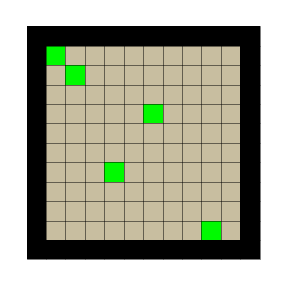

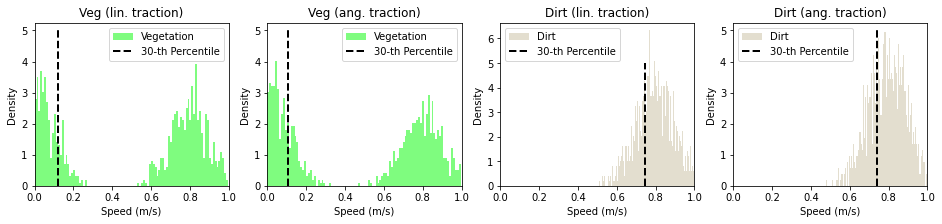

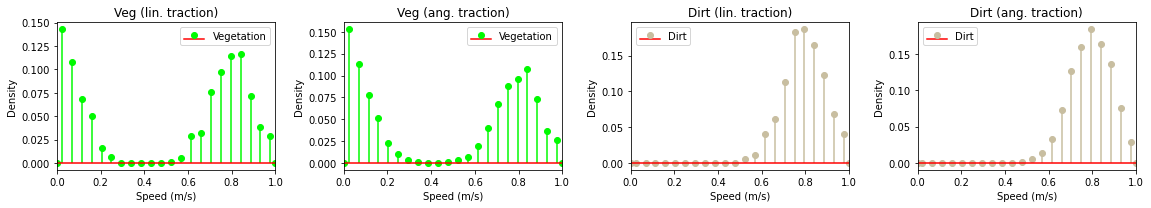

In [17]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3

pmf_bounds = [0, 1.0]
# bush_lin_gm = GaussianMixture(sample_bounds=[0,.8], pmf_bounds=pmf_bounds, weights=[0.5, 0.5], means=[0.1, 0.6], stds=[0.1, 0.1])
# bush_ang_gm = GaussianMixture(sample_bounds=[0,.3], pmf_bounds=pmf_bounds, weights=[0.5, 0.5], means=[0.1, 0.6], stds=[0.1, 0.1])
# dirt_lin_gm = GaussianMixture(sample_bounds=[0, 1.0], pmf_bounds=pmf_bounds, weights=[1], means=[0.8], stds=[0.1])
# dirt_ang_gm = GaussianMixture(sample_bounds=[0, 1.0], pmf_bounds=pmf_bounds, weights=[1], means=[0.8], stds=[0.1])

bush_lin_gm = GaussianMixture(sample_bounds=[0,1.0], pmf_bounds=pmf_bounds, weights=[0.6, 0.4], means=[0, 0.8], stds=[0.1, 0.1])
bush_ang_gm = GaussianMixture(sample_bounds=[0,1.0], pmf_bounds=pmf_bounds, weights=[0.6, 0.4], means=[0, 0.8], stds=[0.1, 0.1])
dirt_lin_gm = GaussianMixture(sample_bounds=[0, 1.0], pmf_bounds=pmf_bounds, weights=[1], means=[0.8], stds=[0.1])
dirt_ang_gm = GaussianMixture(sample_bounds=[0, 1.0], pmf_bounds=pmf_bounds, weights=[1], means=[0.8], stds=[0.1])

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}

grid_shape = (10, 10)
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(*grid_shape)
semantic_grid[rand_num>=0.1] = 0
semantic_grid[rand_num<0.1] = 1

# Assume bin values are the same for linear and angular components for now
res = 1.0
xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf)
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

# # ------------- Create and visualize the map ------------
max_speed = 5.0
lin_tdm = TDM_Numba(max_speed=max_speed)
ang_tdm = TDM_Numba(max_speed=max_speed)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG)
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG)


lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
# ax.set_title("Terrain")

# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_pmf_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_pmf_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_pmf_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_pmf_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

0.6089255809783936
Sampling took 0.3030383586883545s
Copying took 0.0028040409088134766s


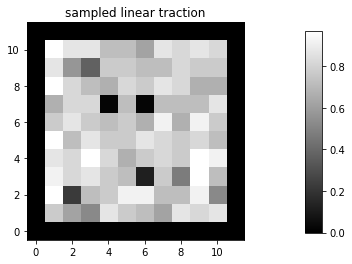

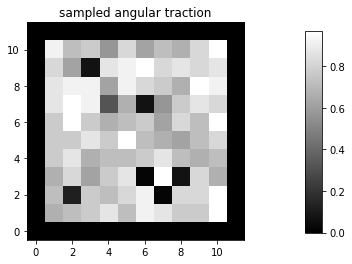

In [3]:
t0 = time.time()
lin_tdm.init_device_vars_before_sampling()
ang_tdm.init_device_vars_before_sampling()
print(time.time()-t0)

t0 = time.time()
lin_sample_grid_batch_d = lin_tdm.sample_grids()
ang_sample_grid_batch_d = ang_tdm.sample_grids()
print("Sampling took {}s".format(time.time()-t0))
t0 = time.time()
lin_sampled = lin_sample_grid_batch_d.copy_to_host()
ang_sampled = ang_sample_grid_batch_d.copy_to_host()
print("Copying took {}s".format(time.time()-t0))

grid_samples = lin_tdm.int8_grid_to_float32(lin_sampled)
fig, ax = plt.subplots()
img = ax.imshow(grid_samples[11], origin='lower', vmin=np.min(grid_samples), vmax=np.max(grid_samples), cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

grid_samples = ang_tdm.int8_grid_to_float32(ang_sampled)
fig, ax = plt.subplots()
img = ax.imshow(grid_samples[1000], origin='lower', vmin=np.min(grid_samples), vmax=np.max(grid_samples), cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

# Sanity checks
assert np.sum(lin_sampled<0)==0
assert np.sum(ang_sampled<0)==0
assert len(lin_sampled[lin_sampled<0]) == 0
assert len(ang_sampled[ang_sampled<0]) == 0

### Closed-loop performance

Given a sampled environment, do receiding horizon planning based on the sampled dynamics.
* Color the traversed part as solid red
* Color the future parts (over X presampled envs) of the optimal solution
  * Do this in GPU as well? (Use already sampled batch on GPU, copy back a subset of the state trajectories)

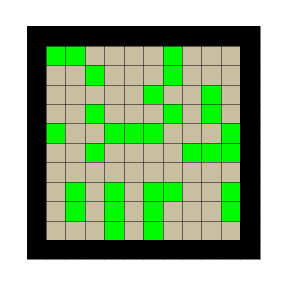

In [5]:
# For now, do in jupyter notebook by visualizing multiple frames of the problem

# ------------- Create and visualize the map ------------
# Fixed a sampled environment
grid_shape = (10, 10)
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(*grid_shape)
perc_grass = 0.2
semantic_grid[rand_num>=perc_grass] = 0
semantic_grid[rand_num<perc_grass] = 1
res = 1.0
max_speed = 5.0
xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

lin_tdm = TDM_Numba(max_speed=max_speed)
ang_tdm = TDM_Numba(max_speed=max_speed)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG)
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG)
lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))

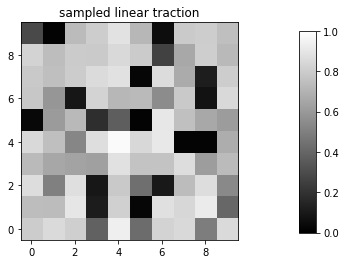

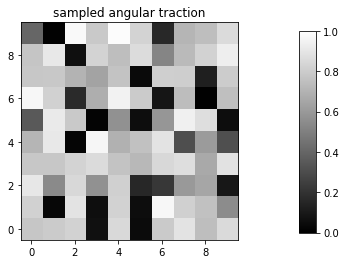

In [6]:
# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()


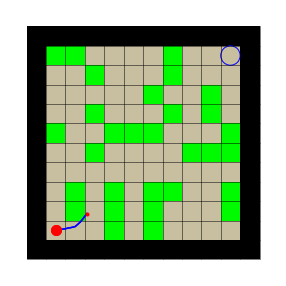

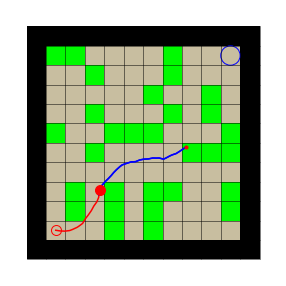

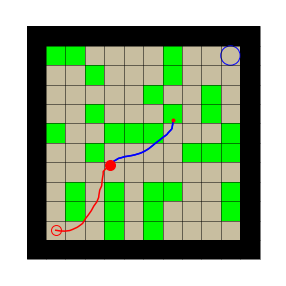

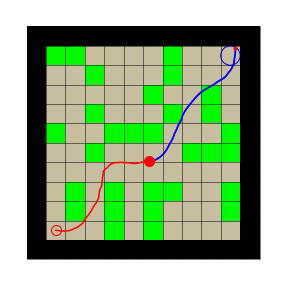

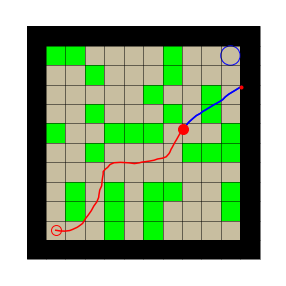

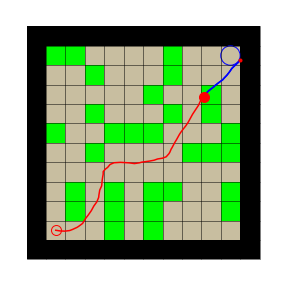

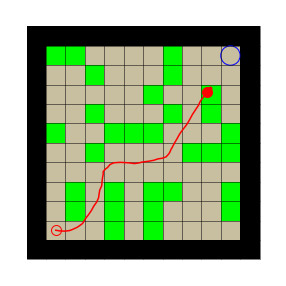

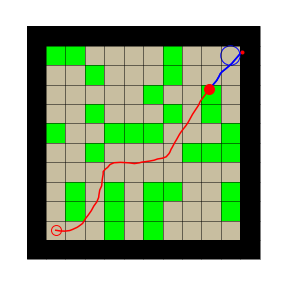

In [13]:
# ------------- Problem configuration ------------
cfg = Config()
u_seq0 = np.zeros((cfg.num_steps, 2), dtype=float)
x0=np.array([0.5, 0.5, 0])
# xgoal= np.array([3.5, 3.5])
xgoal= np.array([9.5, 9.5])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,
    u_seq0=u_seq0,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.1,
    cvar_alpha=1.0, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([3.0, 1.0]),
    vrange = np.array([0, 3]), 
    wrange=np.array([-np.pi, np.pi]),

    # Flags for using variants of MPPI
    use_det_dynamics=True,
    use_nom_dynamics_with_speed_map=False,
)

# Construct the MPPI planner + initialize the GPU variables
mppi_planner = MPPI_Numba()
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
mppi_planner.init_device_vars_before_solving()

# Loop
max_steps = 160
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 20
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal")
    ax.add_patch(c1)

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b')
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    # ax.legend()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break






### Implementation for MPPI without sampling the env.
* Mean vs CVaR(alpha)(passed )

Each block computes the cost. Collaboratively sample the noise. No need to move control sequence to shared memory. 

Pass determinisitc traction map to the MPPI planner. (Try to keep sampe interface as the )

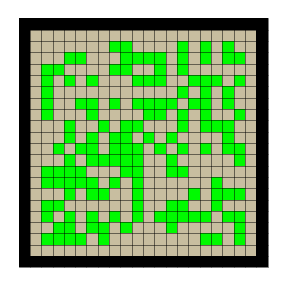

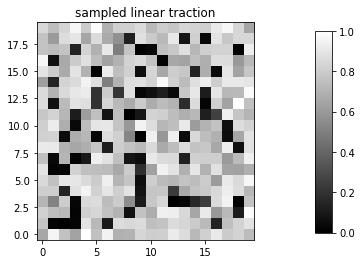

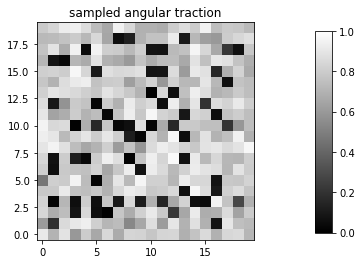

In [30]:
# ------------- Create and visualize the map ------------
# Fixed a sampled environment
# grid_shape = (10, 10)
grid_shape = (20, 20)
mud_margin = 1
res = 1.0
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
perc_grass = 0.5
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1

res = 1.0
max_speed = 3.0
xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

lin_tdm = TDM_Numba(max_speed=max_speed)
ang_tdm = TDM_Numba(max_speed=max_speed)

# ------------- Problem configuration ------------
cfg = Config()
u_seq0 = np.zeros((cfg.num_steps, 2), dtype=float)
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
# xgoal= np.array([3.5, 3.5])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,
    u_seq0=u_seq0,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.05,
    cvar_alpha=0.1, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([3.0, 2.0]),
    vrange = np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),

    # Flags for using deterministic dynamics based on cvar
    use_det_dynamics=False,

    # Flag for using nominal rollouts but with risk-speed adjusted time cost
    use_nom_dynamics_with_speed_map=False,
    
)

# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    mppi_params["use_det_dynamics"], mppi_params['cvar_alpha'], mppi_params["use_nom_dynamics_with_speed_map"])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    mppi_params["use_det_dynamics"], mppi_params['cvar_alpha'], mppi_params["use_nom_dynamics_with_speed_map"])
lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))

# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()



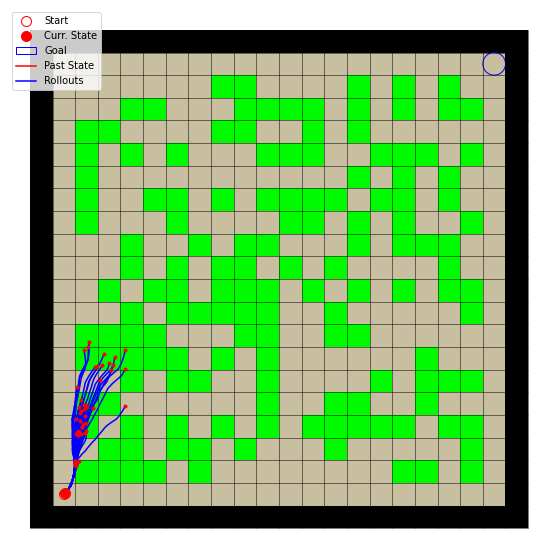

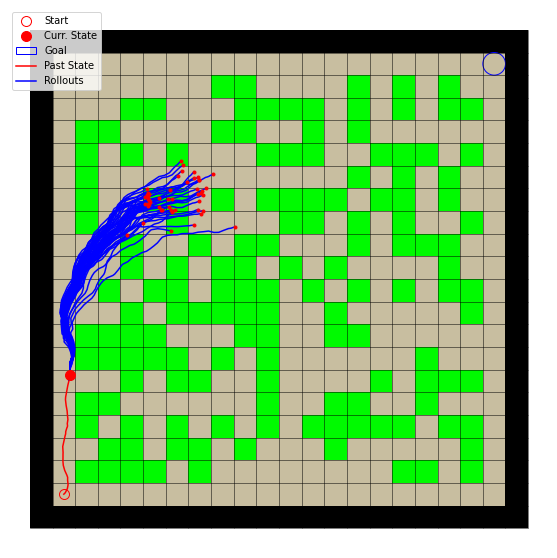

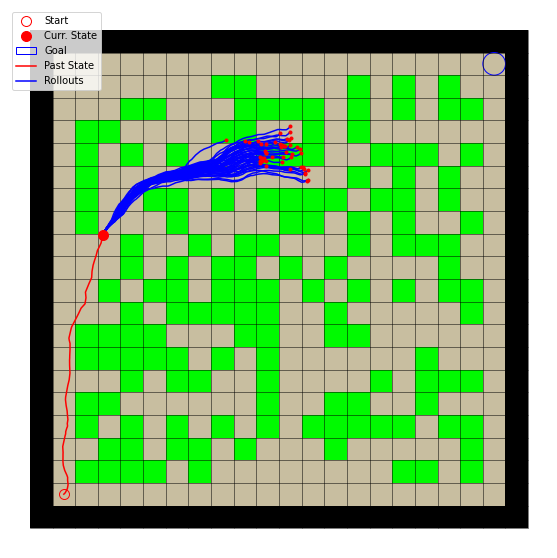

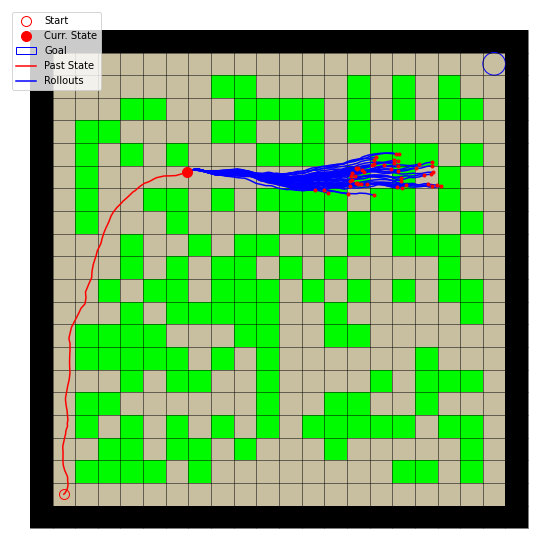

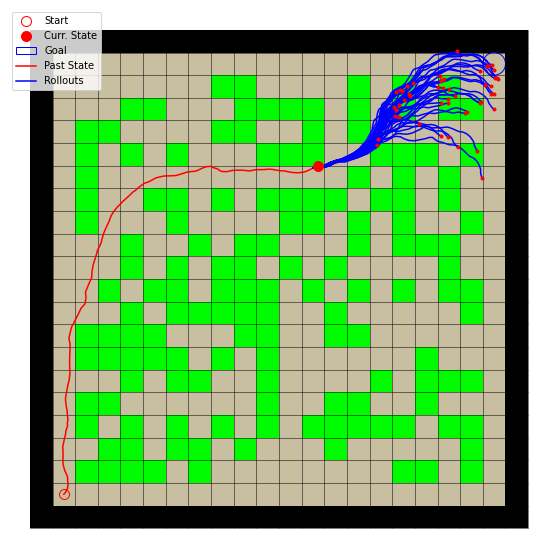

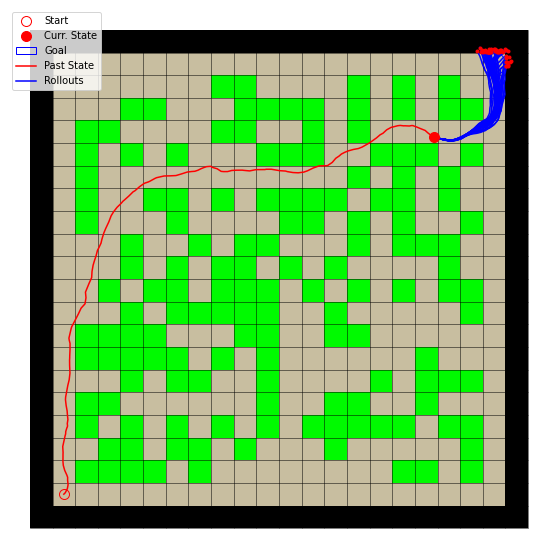

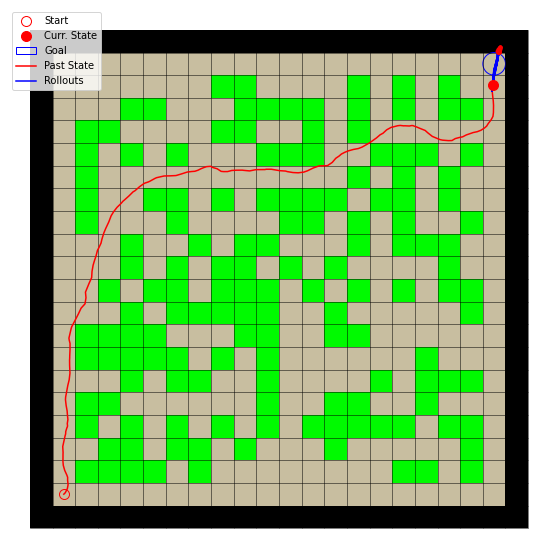

goal reached at t=304


In [31]:

# Construct the MPPI planner + initialize the GPU variables
mppi_planner = MPPI_Numba()
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
mppi_planner.init_device_vars_before_solving()

# Loop
max_steps = 500#150
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 50
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(10,10))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal")
    ax.add_patch(c1)

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b')
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    ax.legend()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break



### Methods to pre-generate the random problem setup (start, goal, envs with grass in middle)

10x10 cells, with the center 8x8 cells populated with grass

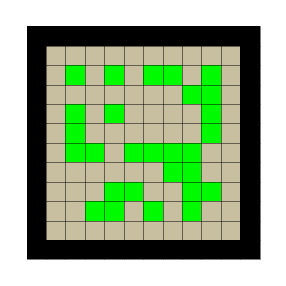

In [43]:
# ------------- Create and visualize the map ------------
# Fixed a sampled environment
grid_shape = (10, 10)
mud_margin = 1
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
perc_grass = 0.4
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1
res = 1.0
max_speed = 3.0
xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

lin_tdm = TDM_Numba(max_speed=max_speed)
ang_tdm = TDM_Numba(max_speed=max_speed)

# ------------- Problem configuration ------------
cfg = Config()
u_seq0 = np.zeros((cfg.num_steps, 2), dtype=float)
x0=np.array([0.5, 0.5, 0])
# xgoal= np.array([3.5, 3.5])
xgoal= np.array([9.5, 9.5])


# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    mppi_params["use_det_dynamics"], mppi_params['cvar_alpha'], mppi_params["use_nom_dynamics_with_speed_map"])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    mppi_params["use_det_dynamics"], mppi_params['cvar_alpha'], mppi_params["use_nom_dynamics_with_speed_map"])
lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))



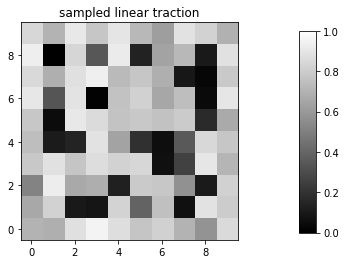

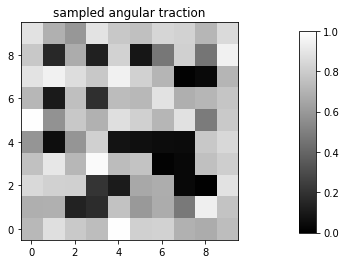

In [44]:
# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()



In [46]:

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,
    u_seq0=u_seq0,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.05,
    cvar_alpha=1.0, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([3.0, 3.0]),
    vrange = np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),

    # Flags for using deterministic dynamics based on cvar
    use_det_dynamics=False,

    # Flag for using nominal rollouts but with risk-speed adjusted time cost
    use_nom_dynamics_with_speed_map=False,
    
)

# Construct the MPPI planner + initialize the GPU variables
mppi_planner = MPPI_Numba()
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
mppi_planner.init_device_vars_before_solving()

# Loop
max_steps = 150
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 30
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal")
    ax.add_patch(c1)

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b')
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    # ax.legend()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break



CudaAPIError: [700] Call to cuMemcpyDtoH results in UNKNOWN_CUDA_ERROR